<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ner_dataset.csv


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


# LOADING AND EXPLORING THE NER DATASET-->

*Essential info about the tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [3]:
df=pd.read_csv("/kaggle/input/ner_dataset.csv",encoding='latin1')
df.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [4]:
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

Looking at the dataset here we will use ffill feature to fill the null values.

In [5]:
df=df.fillna(method='ffill')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [6]:
df.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [7]:
df['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [8]:
n_tags=df['Tag'].nunique()
n_tags

17

In [9]:
n_words=df['Word'].nunique()
n_words

35178

In [10]:
words=list(set(df['Word']))

In [11]:
# words

In [12]:
n_words=len(words)

In [13]:
tags=list(set(df['Tag']))

In [14]:
tags

['B-art',
 'I-art',
 'I-eve',
 'I-geo',
 'O',
 'I-gpe',
 'B-nat',
 'I-nat',
 'B-gpe',
 'I-tim',
 'B-per',
 'I-org',
 'B-org',
 'B-tim',
 'B-eve',
 'B-geo',
 'I-per']

In [15]:
n_tags=len(tags)

In [16]:
class GetSentence(object):
    def __init__(self, data):
        self.n_sentence=1
        self.data=data
        self.empty = False
        function=lambda d:[(w, p, t) for w, p, t in zip(d["Word"].values.tolist(),
                                                        d["POS"].values.tolist(),
                                                        d["Tag"].values.tolist())]
        
        self.group_sent = self.data.groupby("Sentence #").apply(function)
        self.all_sentences = [d for d in self.group_sent] 

In [17]:
get=GetSentence(df)
sentences=get.all_sentences

In [18]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [19]:
sentences[6]

[('He', 'PRP', 'O'),
 ('said', 'VBD', 'O'),
 ('last', 'JJ', 'O'),
 ('week', 'NN', 'O'),
 ("'s", 'POS', 'O'),
 ('tsunami', 'NN', 'O'),
 ('and', 'CC', 'O'),
 ('the', 'DT', 'O'),
 ('massive', 'JJ', 'O'),
 ('underwater', 'NN', 'O'),
 ('earthquake', 'NN', 'O'),
 ('that', 'WDT', 'O'),
 ('triggered', 'VBD', 'O'),
 ('it', 'PRP', 'O'),
 ('has', 'VBZ', 'O'),
 ('affected', 'VBN', 'O'),
 ('millions', 'NNS', 'O'),
 ('in', 'IN', 'O'),
 ('Asia', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('Africa', 'NNP', 'B-geo'),
 ('.', '.', 'O')]

In [20]:
len(sentences)

47959

# For the input of LSTM model all the sentences must be padded to same length,for that we must know the maximum length of the sequence in the list of sentences.

In [21]:
maxl = max([len(s) for s in sentences])
print ('Maximum sequence length in the list of sentences:', maxl)

Maximum sequence length in the list of sentences: 104


# We had splitted each sentences as a list of tuples of the word,POS and tags.

In [22]:
w_index={w:i for i,w in enumerate(words)}
t_index={t:j for j,t in enumerate(tags)}

In [23]:
# w_index

In [24]:
# t_index

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [26]:
maxl

104

This is the length of longest sequence in the list os sentences.
So this should be our size of max_padding

In [27]:
X=[[w_index[w[0]]for w in s]for s in sentences]

In [28]:
X=pad_sequences(maxlen=maxl,padding='post',sequences=X)

In [29]:
X

array([[31084, 23162, 21337, ...,     0,     0,     0],
       [17300, 31112, 15817, ...,     0,     0,     0],
       [17232, 18959, 18840, ...,     0,     0,     0],
       ...,
       [24727, 20700,  4587, ...,     0,     0,     0],
       [24008,  8387, 20860, ...,     0,     0,     0],
       [ 3167, 19032, 16643, ...,     0,     0,     0]], dtype=int32)

In [30]:
Y = [[t_index[w[2]] for w in s] for s in sentences]

In [31]:
Y=pad_sequences(maxlen=maxl,padding='post',sequences=Y)

In [32]:
Y[1]

array([ 8,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 13,  4,
        4,  4, 12,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0], dtype=int32)

In [33]:
# Y

# TRAIN TEST SPLIT-->

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state=42)

In [36]:
import keras.utils

Using TensorFlow backend.


In [37]:
y_train = keras.utils.to_categorical(y_train)

In [38]:
print(x_train.shape, y_train.shape)

(43163, 104) (43163, 104, 17)


In [39]:
print(x_test.shape, y_test.shape)

(4796, 104) (4796, 104)


In [40]:
y_test = keras.utils.to_categorical(y_test)

In [41]:
print(x_test.shape, y_test.shape)

(4796, 104) (4796, 104, 17)


# BIDIRECTIONAL LSTM MODEL-->

In [42]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [43]:
input=Input(shape=(104))
model=Embedding(input_dim=n_words,output_dim=104,input_length=140)(input)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=150,return_sequences=True, recurrent_dropout=0.1))(model)
output = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

# COMBINING INPUT AND OUTPUT LAYERS-->

In [44]:
model=Model(input,output)

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 104)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 104, 104)          3658512   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 104, 104)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 300)          306000    
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           5117      
Total params: 3,969,629
Trainable params: 3,969,629
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [47]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.


In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

# FITTING OUR MODEL-->

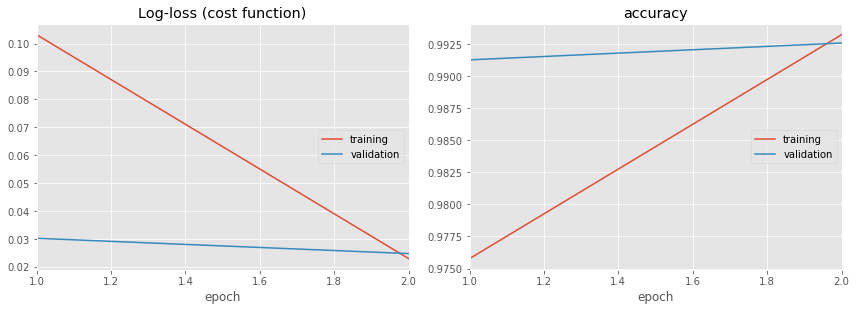

Log-loss (cost function):
training   (min:    0.023, max:    0.103, cur:    0.023)
validation (min:    0.025, max:    0.030, cur:    0.025)

accuracy:
training   (min:    0.976, max:    0.993, cur:    0.993)
validation (min:    0.991, max:    0.993, cur:    0.993)
34530/34530 [==============================] - 415s 12ms/sample - loss: 0.0229 - accuracy: 0.9932 - val_loss: 0.0247 - val_accuracy: 0.9926


In [49]:
early_stop= EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks=[PlotLossesCallback(),early_stop]

history=model.fit(x_train,np.array(y_train),validation_split=0.2,batch_size=32,epochs=2,verbose=1,callbacks=callbacks)

In [50]:
model.evaluate(x_test,np.array(y_test))

4796/4796 [==============================] - 10s 2ms/sample - loss: 0.0249 - accuracy: 0.9926


[0.024935387255153225, 0.99258596]

# The Accuracy turns upto 99.3%

In [51]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true=np.argmax(np.array(y_test),axis=-1)[i]
print("{:15} ({:5}): {}".format("Word", "True", "Predicted by our Model"))

print("--"*20)

for w,true,pred in zip(x_test[i],y_true,p[0]):
    print("{:15}{}\t {}".format(words[w-1],tags[true],tags[pred]))

Word            (True ): Predicted by our Model
----------------------------------------
Musharraf      B-per	 B-per
Azeglio        I-per	 I-per
seventh-seeded O	 O
socio-economic O	 O
Dollar-priced  O	 O
Mosques        O	 O
Aleppo         O	 O
gemstone       O	 O
retroactively  O	 O
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         

In [52]:
p[0]

array([10, 16,  4,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0])

In [53]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true=np.argmax(np.array(y_test),axis=-1)[i]
print("{:15} ({:5}): {}".format("Word", "True", "Predicted by our Model"))

print("--"*10)

for w,true,pred in zip(x_test[i],y_true,p[0]):
    print("{:15}{}\t {}".format(words[w-1],tags[true],tags[pred]))

Word            (True ): Predicted by our Model
--------------------
Musharraf      B-per	 B-per
apostolic      I-per	 I-per
sack           O	 O
plummeting     O	 O
inclusion      B-tim	 B-tim
Buddhist       O	 O
stick          B-per	 O
Massey         I-per	 I-per
auctioneers    O	 O
braved         O	 O
Sangakkara     O	 O
Rafidain       O	 O
braved         O	 O
GINI           O	 O
torn           O	 I-org
nulcear        O	 I-org
Tony           O	 I-org
retroactively  O	 O
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-art	 B-art
crises         B-ar

# See our model is performing quite well

# Now saving our model

In [54]:
model.save_weights('final_model.h5')